In [1]:
# Análises

from pyspark.sql import *
from delta import *

builder = SparkSession.builder.appName("topicos").config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension").config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
spark = configure_spark_with_delta_pip(builder).getOrCreate()

INPUT_PATH = "/home/felipe/code/topicos_dados/dados/"
BRONZE_PATH = "/home/felipe/code/deltalake/lake/bronze/"
SILVER_PATH = "/home/felipe/code/deltalake/lake/silver/"

print(spark.version)


24/03/18 16:34:23 WARN Utils: Your hostname, desktop resolves to a loopback address: 127.0.1.1; using 192.168.0.106 instead (on interface enp6s0)
24/03/18 16:34:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/felipe/.local/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/felipe/.ivy2/cache
The jars for the packages stored in: /home/felipe/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c3f50359-67d0-43b9-b3da-2d4078fbc6a6;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.1.0 in central
	found io.delta#delta-storage;3.1.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 224ms :: artifacts dl 8ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.1.0 from central in [default]
	io.delta#delta-storage;3.1.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0 

3.5.0


In [2]:
df = spark.read.format("delta").load("/home/felipe/code/topicos_dados/lake/silver/silver_brbus/")

df.printSchema()
df.groupBy("city").count().show()

root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- bus_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bus_code: string (nullable = true)
 |-- bus_speed: double (nullable = true)
 |-- bus_direction: integer (nullable = true)
 |-- queried_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)



24/03/18 16:34:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+-------+
|          city|  count|
+--------------+-------+
|Rio de Janeiro|9596168|
|      Brasilia|1110852|
|     Sao Paulo| 105762|
|      Curitiba|   8560|
+--------------+-------+



In [3]:
rj_df = df.filter(df['city'] == 'Rio de Janeiro')
# rj_df.show()

In [8]:
rj_df.summary().show()

+-------+--------------------+-------------------+-------------+--------------+-----------------+------------------+-------------+
|summary|            latitude|          longitude|       bus_id|          city|         bus_code|         bus_speed|bus_direction|
+-------+--------------------+-------------------+-------------+--------------+-----------------+------------------+-------------+
|  count|              102302|             102302|       102302|        102302|           102302|            102302|            0|
|   mean|  -22.89725239662956|-43.333510612891274|         NULL|          NULL|677.6886725960732| 17.63520752282458|         NULL|
| stddev|0.053616704371144734|0.11791877456353878|         NULL|          NULL|527.2197615945445|19.942763553230037|         NULL|
|    min|           -23.06681|          -43.75761|   RJO_A27501|Rio de Janeiro|                0|               0.0|         NULL|
|    25%|           -22.93087|           -43.3713|         NULL|          NULL|    

In [4]:
bsb_df = df.filter(df['city'] == 'Brasilia')
# bsb_df = bsb_df.where((df.updated_at > '2024-01-30 20:15:00') & (df.updated_at < '2024-01-30 20:30:00'))
# bsb_df.show()

In [7]:
bsb_df.summary().show()

+-------+-------------------+-------------------+----------+--------+-----------------+-----------------+------------------+
|summary|           latitude|          longitude|    bus_id|    city|         bus_code|        bus_speed|     bus_direction|
+-------+-------------------+-------------------+----------+--------+-----------------+-----------------+------------------+
|  count|               6957|               6957|      6957|    6957|             6957|             2358|              6957|
|   mean|-15.827125689808833| -47.92874969656462|      NULL|    NULL|650.1742394710353|16.64821458863444|1.0369412102917925|
| stddev|0.10983335650361845|0.12928672964295884|      NULL|    NULL|1032.611738780902|16.02818807524949|0.7483455116038568|
|    min|         -16.049818|         -48.152668|BSB_115291|Brasilia|            0.018|              0.0|                 0|
|    25%|         -15.889977|          -48.04858|      NULL|    NULL|            0.641|             5.56|                 0|


[18.337033000302757, 17.03914205893839, 16.64327128843258, 16.264997275474315, 15.830368619385906, 15.522712033258616, 15.151470082758255, 14.984485795727508, 14.623132514911477, 14.385356670905328, 14.069720293079119, 14.452813541996251, 15.003017508926542, 16.248940971784464, 17.751472701876555, 18.29211673151751, 16.728620914704553] [14.705259158443907, 14.756202263963187, 13.964074617737007, 14.179960413459437, 13.384202348475865, 13.727655708308415, 12.840224743381945, 12.315724027986889, 11.601859382275348, 12.500842228282053, 14.308554385210657, 15.84056517602281, 16.11339181286549, 16.598848431024273, 18.254564234990315, None, None]


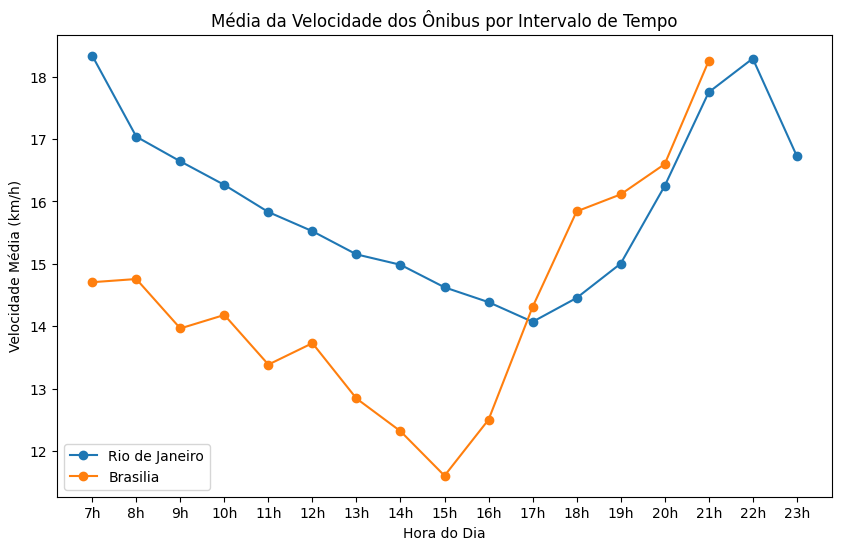

In [6]:
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt

hours = ["7h", "8h", "9h", "10h", "11h", "12h", "13h", "14h", "15h", "16h", "17h", "18h", "19h", "20h", "21h", "22h", "23h"]
date = "2024-02-02"
intervals = [
    ("06:50",  "07:10"),
    ("07:50",  "08:10"),
    ("08:50",  "09:10"),
    ("09:50",  "10:10"),
    ("10:50",  "11:10"),
    ("11:50",  "12:10"),
    ("12:50",  "13:10"),
    ("13:50",  "14:10"),
    ("14:50",  "15:10"),
    ("15:50",  "16:10"),
    ("16:50",  "17:10"),
    ("17:50",  "18:10"),
    ("18:50",  "19:10"),
    ("19:50",  "20:10"),
    ("20:50",  "21:10"),
    ("21:50",  "22:10"),
    ("22:50",  "23:10"),
]


def getAvg(dates, df):
    date_from, date_to = f"{date} {dates[0]}:00", f"{date} {dates[1]}:00"
    #print(date_from, date_to)
    filter = df.where((df.updated_at > date_from) & (df.updated_at < date_to))
    return filter.agg({"bus_speed": "avg"}).collect()[0][0]

rj_avgs = [getAvg(date, rj_df) for date in intervals]
bsb_avgs = [getAvg(date, bsb_df) for date in intervals]
print(rj_avgs, bsb_avgs)


plt.figure(figsize=(10, 6))
plt.plot(hours, rj_avgs, marker='o', label='Rio de Janeiro')
plt.plot(hours, bsb_avgs, marker='o', label='Brasilia')
plt.legend()
plt.title("Média da Velocidade dos Ônibus por Intervalo de Tempo")
plt.xlabel("Hora do Dia")
plt.ylabel("Velocidade Média (km/h)")
#plt.grid(True)
#plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()

In [8]:
sp_df = df.filter(df['city'] == 'Sao Paulo')
sp_df.show()

+-------------------+-------------------+---------+---------+--------+---------+-------------+-------------------+-------------------+
|           latitude|          longitude|   bus_id|     city|bus_code|bus_speed|bus_direction|         queried_at|         updated_at|
+-------------------+-------------------+---------+---------+--------+---------+-------------+-------------------+-------------------+
|         -23.552871|-46.647738000000004|SPO_71212|Sao Paulo| 609F-10|     NULL|         NULL|2024-01-30 19:39:15|2024-01-30 19:39:09|
|        -23.6532175| -46.74036099999999|SPO_71739|Sao Paulo| 609F-10|     NULL|         NULL|2024-01-30 19:39:15|2024-01-30 19:38:46|
|        -23.6680755|         -46.748797|SPO_71361|Sao Paulo| 609F-10|     NULL|         NULL|2024-01-30 19:39:15|2024-01-30 19:38:37|
|         -23.534974|        -46.6443435|SPO_71740|Sao Paulo| 609F-10|     NULL|         NULL|2024-01-30 19:39:15|2024-01-30 19:38:55|
|        -23.6168605| -46.70167549999999|SPO_71839|Sao 

In [12]:
import folium
from folium.plugins import HeatMap

date = "2024-01-30"
def getCoordinates(date_from, date_to):
  date_from = f"{date} {date_from}:00"
  date_to =  f"{date} {date_to}"

  filtered = sp_df.where((sp_df.updated_at > date_from) & (sp_df.updated_at < date_to))
  filtered = filtered.select('latitude', 'longitude')
  #filtered.show()

  coordinates = filtered.rdd.map(lambda x: (x.latitude, x.longitude)).collect()
  return coordinates

m = folium.Map(location=[-23.5503099,-46.6367758], width='50%', height='50%', zoom_start=13) #o centro do mapa são as coordenadas da praça da sé
HeatMap(getCoordinates('19:30', '19:40'), radius=12).add_to(m)
m

In [13]:
m = folium.Map(location=[-23.5503099,-46.6367758], width='50%', height='50%', zoom_start=13) #o centro do mapa são as coordenadas da praça da sé
HeatMap(getCoordinates('20:00', '20:10'), radius=12).add_to(m)
m

In [37]:
# Generating Gold for Geometry

rj_df_filtered = rj_df.select(rj_df["latitude"],rj_df["longitude"],rj_df['updated_at'], rj_df["bus_id"])
rj_df_filtered = rj_df_filtered.sort(rj_df_filtered['updated_at'],ascending=False)
rj_df_filtered.write.format("delta").option("path","/home/felipe/code/topicos_dados/lake/gold/gold_plot").saveAsTable("gold_plot")

gold_plot = spark.read.format("delta").load("/home/felipe/code/topicos_dados/lake/gold/gold_plot")
gold_plot.show()


24/03/18 21:11:47 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers
24/03/18 21:11:47 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 84,44% for 9 writers
24/03/18 21:11:47 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 76,00% for 10 writers
24/03/18 21:11:47 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 69,09% for 11 writers
24/03/18 21:11:47 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 63,33% for 12 writers
24/03/18 21:11:50 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 69,09% for 11 writers
24/03/18 21:11:50 WARN MemoryManager: Total allocation exceeds 95,

+---------+---------+-------------------+----------+
| latitude|longitude|         updated_at|    bus_id|
+---------+---------+-------------------+----------+
|-22.95812|-43.26435|2024-02-02 14:51:58|RJO_C50114|
|-22.83239|-43.24277|2024-02-02 14:51:58|RJO_B28610|
|-22.83904|-43.36357|2024-02-02 14:51:58|RJO_B11547|
|-22.90648|-43.17758|2024-02-02 14:51:58|RJO_A48130|
|-22.93125|-43.17893|2024-02-02 14:51:58|RJO_A71523|
|-22.87545| -43.3392|2024-02-02 14:51:58|RJO_C44568|
|-22.87997|-43.46644|2024-02-02 14:51:58|RJO_D13089|
|-22.88654|-43.39417|2024-02-02 14:51:58|RJO_B51601|
| -22.9293| -43.3919|2024-02-02 14:51:58|RJO_C47708|
|-22.98449|-43.22337|2024-02-02 14:51:58|RJO_A63505|
| -22.9109|-43.21968|2024-02-02 14:51:58|RJO_B25600|
|-22.83792|-43.29457|2024-02-02 14:51:58|RJO_B63023|
|-22.90795|-43.19577|2024-02-02 14:51:58|RJO_B31029|
|-22.90349|-43.55654|2024-02-02 14:51:58|RJO_D86032|
|-22.95404|-43.57727|2024-02-02 14:51:58|RJO_D86060|
|-22.99998|-43.37821|2024-02-02 14:51:58|RJO_D

In [28]:
import folium

mapa_linha = folium.Map(location=[-22.92571,-43.24503], zoom_start=12)
cont = 0
for i,val in enumerate(rj_df_filtered.select(rj_df_filtered["latitude"],rj_df_filtered["longitude"]).collect()):
    if cont == 30:
        break
    
    lat, lon = val
    cont+=1
    folium.Marker((lat,lon),).add_to(mapa_linha)

mapa_linha

# Aqui os dados demonstrando que estão no terminal

In [32]:
import folium

mapa_linha = folium.Map(location=[-22.92571,-43.24503], zoom_start=12)
cont = 0

rj_selected = rj_df_filtered.where((rj_df_filtered.updated_at > "2024-02-02 12:00:00") & (rj_df_filtered.updated_at < "2024-02-02 14:00:00"))

for i,val in enumerate(rj_selected.select(rj_selected["latitude"],rj_selected["longitude"]).collect()):
    if cont == 40:
        break
    
    lat, lon = val
    cont+=1
    folium.Marker((lat,lon),).add_to(mapa_linha)

mapa_linha

# Aqui os dados demonstrando que estão no terminal